# Configure GPU Usage

In [1]:
%load_ext autoreload
%autoreload 2

from keras import backend as K
import tensorflow as tf
import numpy as np
import os

# use tensorflow backend
os.environ['KERAS_BACKEND'] = 'tensorflow'

# allow dynamic GPU memory allocation
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# identify available GPU's
gpus = K.tensorflow_backend._get_available_gpus()

# set random seeds
tf.set_random_seed(1)
np.random.seed(1)

/home/cuda/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


ImportError: Traceback (most recent call last):
  File "/home/cuda/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/cuda/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/cuda/anaconda3/lib/python3.6/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
  File "/home/cuda/anaconda3/lib/python3.6/imp.py", line 243, in load_module
    return load_dynamic(name, filename, file)
  File "/home/cuda/anaconda3/lib/python3.6/imp.py", line 343, in load_dynamic
    return _load(spec)
ImportError: libcublas.so.10.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/errors

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [77]:
gpus

['/job:localhost/replica:0/task:0/device:GPU:0']

# Configure Data

In [78]:
import glob

labels = ['ARIEL', 'C7', 'CLAV', 'LANK', 'LBHD', 'LBSH', 'LBWT', 'LELB', 'LFHD', 'LFRM', 'LFSH', 'LFWT', 'LHEL', 'LIEL', 'LIHAND', 'LIWR', 'LKNE', 'LKNI', 'LMT1', 'LMT5', 'LOHAND', 'LOWR', 'LSHN', 'LTHI', 'LTOE', 'LUPA', 'LabelingHips', 'MBWT', 'MFWT', 'RANK', 'RBHD', 'RBSH', 'RBWT', 'RELB', 'RFHD', 'RFRM', 'RFSH', 'RFWT', 'RHEL', 'RIEL', 'RIHAND', 'RIWR', 'RKNE', 'RKNI', 'RMT1', 'RMT5', 'ROHAND', 'ROWR', 'RSHN', 'RTHI', 'RTOE', 'RUPA', 'STRN', 'SolvingHips', 'T10']    

bad_labels = ['SolvingHips', 'LabelingHips']

edge_groups = [
  # head
  ['ARIEL', 'RFHD', 'RBHD', 'LFHD', 'LBHD'],
  ['ARIEL', 'CLAV'],
  # right arm
  ['CLAV', 'RELB'],
  ['RELB', 'RIWR'],
  # left arm
  ['CLAV', 'LELB'],
  ['LELB', 'LIWR'],
  # body
  ['CLAV', 'STRN'],
  # right leg
  ['STRN', 'RKNE'],
  ['RKNE', 'RMT5'],
  # left leg
  ['STRN', 'LKNE'],
  ['LKNE', 'LMT5'],
]

infile_glob = sorted(glob.glob('data/mariel_*'))

In [79]:
infile_glob

['data/mariel_betternot_and_retrograde.npy',
 'data/mariel_beyond.npy',
 'data/mariel_chunli.npy',
 'data/mariel_honey.npy',
 'data/mariel_knownbetter.npy',
 'data/mariel_penelope.npy']

In [80]:
from itertools import combinations


class Data:
  def __init__(self, file_glob, labels, bad_labels, edge_groups):
    # params
    self.files = file_glob
    self.labels = labels
    self.bad_labels = bad_labels
    self.edge_groups = edge_groups
    self.filtered_labels = [i for i in labels if i not in bad_labels]
    
    # parsed structures
    self.all_vertices = self.get_all_vertices()
    
    # fully composed datasets; each has `X`, `labels`, and `edges` attrs
    self.full = self.get_full_dataset()
    self.selected = self.get_selected_dataset()

  def get_all_vertices(self):
    '''Load each of the data files'''
    # load all vertices dataset
    file_data = []
    for i in self.files:
      file_data.append(np.swapaxes(np.load(i), 0, 1))
    X = np.swapaxes(np.vstack(file_data), 0, 1) # stack the time frames then make time 1st dim
    X = self.rotate(X, -np.pi/2, 'x') # rotate the matrix into proper orientation
    # filter out the bad vertices using the bad labels
    bad_indices = [idx for idx, i in enumerate(self.labels) if i in self.bad_labels]
    idx_mask = np.ones(X.shape[0], dtype=bool)
    idx_mask[bad_indices] = 0
    X = X[idx_mask]
    return X

  def get_full_dataset(self):
    '''Load the full 53 vertex dataset with edges from rigidity analysis'''
    X = self.scale(self.all_vertices)
    return Dataset(X, self.filtered_labels, self.get_rigid_edges(X))

  def get_rigid_edges(self, X):
    '''Get the edges discovered through rigidity analysis on X'''
    vdist_var = np.zeros((X.shape[0], X.shape[0]))
    for i in range(X.shape[0]):
      for j in range(i+1, X.shape[0]):
        vdist = np.sum((X[i]-X[j])**2, axis=-1)
        vdist_var[i,j] = vdist_var[j,i] = vdist.var(ddof=1)
    upper_triangle = np.triu_indices_from(vdist_var, k=1)
    vtx_pairs = sorted(zip(*upper_triangle), key=lambda p: vdist_var[p[0], p[1]])
    return vtx_pairs

  def get_selected_dataset(self):
    '''Load just the selected vertices and their associated edges'''
    selected_edges = self.get_selected_edges() # [[self.all_vertices_idx_i, self.all_vertices_idx_j]]
    selected_vertices = sorted(list(set([j for i in selected_edges for j in i]))) # flatten and sort
    # create a copy of X with fewer vertices; shape = (verts, time, dims)
    idx_mask = np.zeros(self.all_vertices.shape[0], dtype=bool)
    idx_mask[selected_vertices] = 1
    X = self.all_vertices[idx_mask]
    # create a copy of selected_edges that indexes into _X (aka X with reduced vertex count)
    d = {i: idx for idx, i in enumerate(selected_vertices)} # maps vert idx in self.all_vertices to idx in X
    edges = [ [d[i], d[j]] for i, j in selected_edges ]
    labels = [self.filtered_labels[d[i]] for i in d.keys()]
    return Dataset(X, labels, edges)
  
  def get_selected_edges(self):
    '''Get just the edges required to compose the frame for select vertices'''
    selected_edges = []
    label_to_idx = {i: idx for idx, i in enumerate(self.filtered_labels)}
    for g in self.edge_groups:
      for i, j in combinations(g, 2):   
        i = label_to_idx[i]
        j = label_to_idx[j]
        selected_edges.append([i, j])
    return selected_edges

  def scale(self, X):
    '''Scale all dimensions in X 0:1'''
    # center the data for visualization
    X -= np.amin(X, axis=(0, 1))
    X /= np.amax(X, axis=(0, 1))
    X[:,:,2] *= -1
    X[:,:,2] += 1
    return X
    
  def rotate(self, X, theta, axis='x'):
    '''Rotate multidimensional array `X` `theta` degrees around axis `axis`'''
    c, s = np.cos(theta), np.sin(theta)
    if axis == 'x': return np.dot(X, np.array([
      [1.,  0,  0],
      [0 ,  c, -s],
      [0 ,  s,  c]
    ]))
    elif axis == 'y': return np.dot(X, np.array([
      [c,  0,  -s],
      [0,  1,   0],
      [s,  0,   c]
    ]))
    elif axis == 'z': return np.dot(X, np.array([
      [c, -s,  0 ],
      [s,  c,  0 ],
      [0,  0,  1.],
    ]))

class Dataset:
  def __init__(self, X, labels, edges):
    self.X = X
    self.labels = labels
    self.edges = edges
    self.diffs = self.get_diffs()

  def get_diffs(self):
    '''Return vertices stored in relative change from last frame, not absolute coords'''
    return np.diff(self.X, axis=1)

  def from_diffs(self):
    '''Return vertices in absolute coords, not relative change from last frame'''
    initial = X[:,0:1,:]
    return np.cumsum( np.concatenate([initial, diffs], axis=1), axis=1 )

##
# Configure Data
##

data = Data(infile_glob, labels, bad_labels, edge_groups)

# Visualization Helpers

In [81]:
import mpl_toolkits.mplot3d.axes3d as p3
from mpl_toolkits.mplot3d.art3d import juggle_axes
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib import animation
import matplotlib

# ask matplotlib to plot up to 2^128 frames in animations
matplotlib.rcParams['animation.embed_limit'] = 2**128

def update_points(time, points, df, params):
  '''
  Callback function called by plotting function below. Mutates the vertex
  positions of each value in `points` so the animation moves
  @param int time: the index of the time slice to visualize within `df`
  @param mpl_toolkits.mplot3d.art3d.Path3DCollection points: geometry to mutate
  @param numpy.ndarray df: a 2D numpy array with shape d[vert][time][dimension]
  '''
  points._offsets3d = juggle_axes(df[:,time,0], df[:,time,1], df[:,time,2], 'z')

def update_lines(time, lines, df, params):
  '''
  Callback function called by plotting function below. Mutates the vertex
  positions of each value in `points` so the animation moves
  @param int time: the index of the time slice to visualize within `df`
  @param mpl_toolkits.mplot3d.art3d.Path3DCollection lines: geometry to mutate
  @param numpy.ndarray df: a 2D numpy array with shape d[vert][time][dimension]
  '''
  new_positions = [ [df[i,time,:], df[j,time,:]] for i, j in params['edges'] ]
  for idx, line in enumerate(lines):
    a, b = new_positions[idx]
    line[0].set_data([a[0], b[0]], [a[1], b[1]])
    line[0].set_3d_properties([a[2], b[2]])
  return lines

def animate(df, edges=[], axes=None, frames=50, speed=45, figsize=(7,5), colors=None):
  '''
  General function that can plot numpy arrays in either of two shapes.
  @param numpy.ndarray df: a 2D numpy array with shape d[vert][time][dimension]
  @param numpy.ndarray edges: 2 2D numpy array with shape [[i, j]] where i and j
    are indices into the `vertices` in X
  @param dict axes: dict that maps {x, y, z} keys to (min_axis_val, max_axis_val)
  @param int frames: the number of time slices to animate
  @param int speed: the temporal duration of each frame. Increase to boost fps
  @param tuple figsize: the size of the figure to render
  @param {str|list}: string or list of  color values (if list, one per edge to be drawn)
  '''
  if axes is None:
    axes = {'x': (0,1), 'y': (0,1), 'z': (0, 1.5)}
  fig = plt.figure(figsize=figsize)
  ax = p3.Axes3D(fig)
  ax.set_xlim(*axes['x'])
  ax.set_ylim(*axes['y'])
  ax.set_zlim(*axes['z'])
  if edges:
    params = {'edges': edges}
    callback = update_lines
    lines, geoms = [ [df[i,0,:], df[j,0,:]] for i, j in edges ], []
    for idx, i in enumerate(lines):
      if colors and isinstance(colors, list): c = colors[idx]
      elif colors: c = colors
      else: c = plt.cm.RdYlBu(idx/len(lines))
      geoms.append( ax.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], [i[0][2], i[1][2]], color=c) )
  else:
    params = None
    callback = update_points
    geoms = ax.scatter(df[:,0,0], df[:,0,1], df[:,0,2], depthshade=False) # x,y,z vals
  return animation.FuncAnimation(fig,
    callback,
    frames,
    interval=speed,
    fargs=(geoms, df, params),
    blit=False  
  ).to_html5_video()

def plot_labelled_points(x=None, frame_idx=0, figsize=(14,10), font_size=8, axes=None, text=True):
  '''
  Plot the vertices from a body with index numbers next to them (useful for cherry-
  picking vertices to keep in a model)
  @param numpy.ndarray x: a 3D numpy array with shape X[vert][time][dimension]
  @param int frame_idx: the index position of the frame to draw
  @param dict axes: dict that maps {x, y, z} keys to (min_axis_val, max_axis_val)
  @param tuple figsize: the size of the figure to render
  @param bool text: whether or not to label the vertices with text
  '''
  if axes is None:
    axes = {'x': (0,1), 'y': (0,1), 'z': (0, 1.5)}
  fig = plt.figure(figsize=figsize)
  ax = fig.add_subplot(111, projection='3d')
  ax.set_xlim(*axes['x'])
  ax.set_ylim(*axes['y'])
  ax.set_zlim(*axes['z'])
  m = x[:,frame_idx,:].squeeze() # m is an array of (x,y,z) coordinate triplets
  for i in range(len(m)): # plot each point + it's index as text above
    if text:
      ax.text(m[i,0], m[i,1], m[i,2], '%s' % (labels[i]), size=font_size, zorder=1, color='k')
    else:
      ax.scatter(m[i,0], m[i,1], m[i,2], color='b')
      ax.text(m[i,0], m[i,1], m[i,2], '%s' % (i), size=font_size, zorder=1, color='k')

def plot_lines(x=None, time_idx=0, edges=[], axes=None, colors=None, figsize=(7,5)):
  '''
  Plot edges between a collection of vertex pairs
  @param numpy.ndarray x: a 3D numpy array with shape [vertex][time][dimension]
  @param numpy.ndarray edges: 2 2D numpy array with shape [[i, j]] where i and j
    are indices into the `vertices` in `x`
  @param int time_idx: the time slice for which we will draw lines
  @param dict axes: dict that maps {x, y, z} keys to (min_axis_val, max_axis_val)
  @param list colors: list of color values, one per edge to be drawn
  @param tuple figsize: the size of the figure to render
  '''
  if axes is None:
    axes = {'x': (0,1), 'y': (0,1), 'z': (0, 1.5)}
  fig = plt.figure(figsize=figsize)
  ax = p3.Axes3D(fig)
  ax.set_xlim(*axes['x'])
  ax.set_ylim(*axes['y'])
  ax.set_zlim(*axes['z'])
  lines = [ [X[i,time_idx,:], X[j,time_idx,:]] for i, j in edges ]
  for idx, i in enumerate(lines):
    c = colors[idx] if colors else plt.cm.RdYlBu(idx/len(lines))
    ax.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], [i[0][2], i[1][2]], color=c)

In [82]:
def update_lines_ghost(time, lines_real, df_real, lines_pred, df_pred, params, ghost_shift):
  '''
  Callback function called by plotting function below. Mutates the vertex
  positions of each value in `points` so the animation moves
  @param int time: the index of the time slice to visualize within `df`
  @param mpl_toolkits.mplot3d.art3d.Path3DCollection lines: geometry to mutate
  @param numpy.ndarray df: a 2D numpy array with shape d[vert][time][dimension]
  '''
  new_positions_real = [ [df_real[i,time,:], df_real[j,time,:]] for i, j in params['edges'] ]
  for idx, line in enumerate(lines_real):
    a, b = new_positions_real[idx]
    line[0].set_data([a[0], b[0]], [a[1], b[1]])
    line[0].set_3d_properties([a[2], b[2]])
    
  new_positions_pred = [ [df_pred[i,time,:], df_pred[j,time,:]] for i, j in params['edges'] ]
  for idx, line in enumerate(lines_pred):
    a, b = new_positions_pred[idx]
    line[0].set_data([a[0]-ghost_shift, b[0]-ghost_shift], [a[1], b[1]])
    line[0].set_3d_properties([a[2], b[2]])
  return lines_pred

def animate_ghost(df_real, df_pred, edges=[], axes=None, frames=50, speed=45, figsize=(7,5), colors=None, ghost_shift=0.3):
  '''
  General function that can plot numpy arrays in either of two shapes.
  @param numpy.ndarray df: a 2D numpy array with shape d[vert][time][dimension]
  @param numpy.ndarray edges: 2 2D numpy array with shape [[i, j]] where i and j
    are indices into the `vertices` in X
  @param dict axes: dict that maps {x, y, z} keys to (min_axis_val, max_axis_val)
  @param int frames: the number of time slices to animate
  @param int speed: the temporal duration of each frame. Increase to boost fps
  @param tuple figsize: the size of the figure to render
  @param {str|list}: string or list of  color values (if list, one per edge to be drawn)
  '''
  if axes is None:
    axes = {'x': (0,1), 'y': (0,1), 'z': (0, 1.5)}
  fig = plt.figure(figsize=figsize)
  ax = p3.Axes3D(fig)
  ax.set_xlim(*axes['x'])
  ax.set_ylim(*axes['y'])
  ax.set_zlim(*axes['z'])
  if edges:
    params = {'edges': edges}
    callback = update_lines_ghost
    lines_real, geoms_real = [ [df_real[i,0,:], df_real[j,0,:]] for i, j in edges ], []
    for idx, i in enumerate(lines_real):
        c = 'black'
#       if colors and isinstance(colors, list): c = colors[idx]
#       elif colors: c = colors
#       else: c = plt.cm.RdYlBu(idx/len(lines_real))
        geoms_real.append( ax.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], [i[0][2], i[1][2]], color=c) )
    lines_pred, geoms_pred = [ [df_pred[i,0,:], df_pred[j,0,:]] for i, j in edges ], []
    for idx, i in enumerate(lines_pred):
      if colors and isinstance(colors, list): c = colors[idx]
      elif colors: c = colors
      else: c = plt.cm.RdYlBu(idx/len(lines_pred))
      geoms_pred.append( ax.plot([i[0][0], i[1][0]], [i[0][1], i[1][1]], [i[0][2], i[1][2]], color=c) )
  else:
    params = None
    callback = update_points_ghost
    geoms_real = ax.scatter(df_real[:,0,0], df_real[:,0,1], df_real[:,0,2], depthshade=False) # x,y,z vals
    geoms_pred = ax.scatter(df_pred[:,0,0], df_pred[:,0,1], df_pred[:,0,2], depthshade=False) # x,y,z vals
  return animation.FuncAnimation(fig,
    callback,
    frames,
    interval=speed,
    fargs=(geoms_real, df_real, geoms_pred, df_pred, params, ghost_shift),
    blit=False  
  ).to_html5_video()

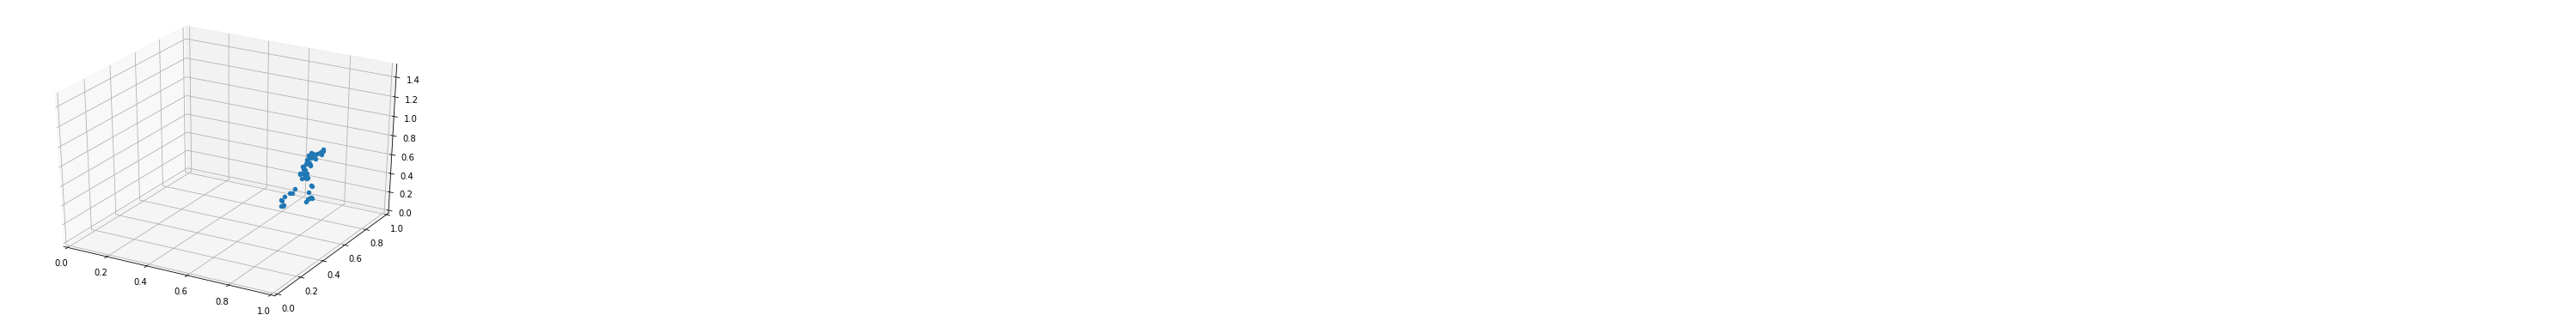

In [83]:
HTML(animate(data.full.X[:,15000:,:], frames=50))

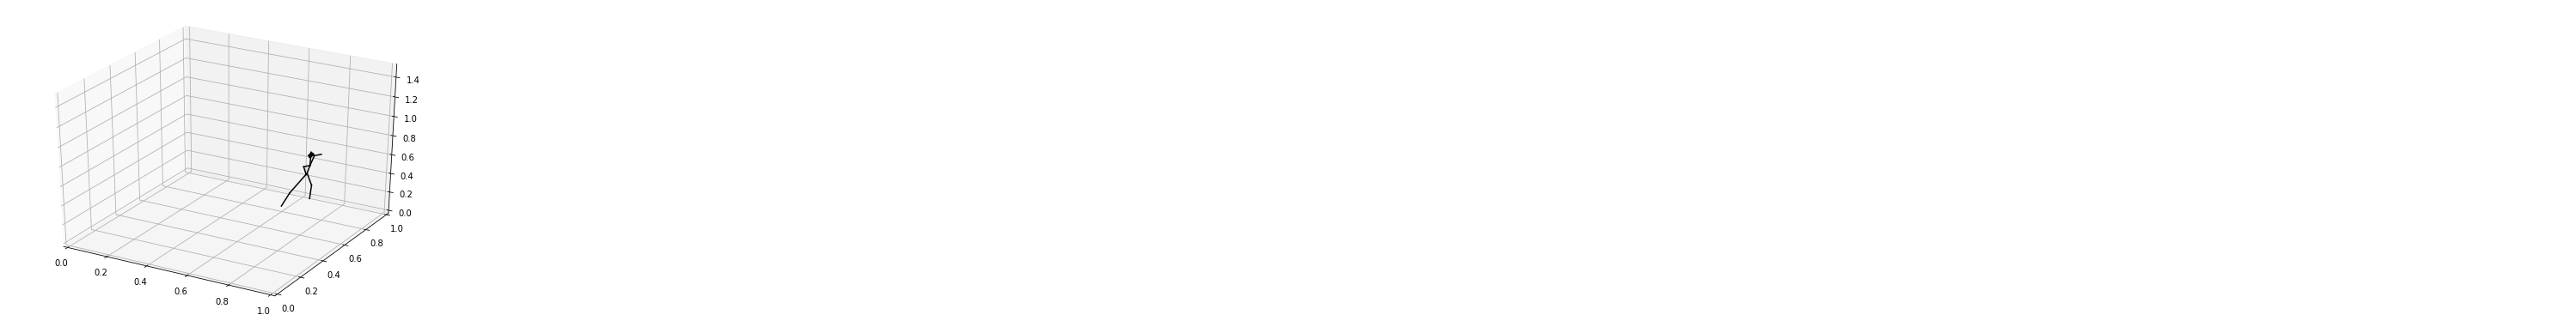

In [84]:
HTML(animate(data.selected.X[:,15000:,:], frames=50, edges=data.selected.edges, colors='black'))

In [10]:
# plot the body with labels for cherry picking edges
# plot_labelled_points(data.full.X, frame_idx=11000, text=True, figsize=(50,40), font_size=8)

In [11]:
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten, Dropout, LeakyReLU, Add, Subtract, Lambda

class Autoencoder:
  def __init__(self,
               n_verts=0,
               n_dims=3,
               latent_dim=2,
               n_layers=2,
               n_units=128,
               relu=False,
               add_random_offsets=False,
               dropout=False):
    if not n_verts: raise Exception('Please provide the number of vertices `n_verts`')
    self.n_verts = n_verts # input vert count
    self.n_dims = n_dims # input dimensions
    self.relu = relu # whether to add relu layers in encoder/decoder
    self.dropout = dropout # whether to add dropout layers in encoder/decoder
    self.latent_dim = latent_dim
    self.n_layers = n_layers
    self.n_units = n_units
    self.encoder = self.build_encoder()
    self.decoder = self.build_decoder()
    # attach the encoder and decoder
    i = Input((self.n_verts, self.n_dims))
    if add_random_offsets:
        random_offsets = K.cast(K.learning_phase(),'float')*K.random_uniform((K.shape(i)[0],1,3))*K.constant([[[1,1,0]]])
        offset_layer = Lambda(lambda x: x + random_offsets)
        offset_layer.uses_learning_phase = True
        i_offset = offset_layer(i)
    else: 
        i_offset = i
    z = self.encoder(i_offset) # push observations into latent space
    o = self.decoder(z) # project from latent space to feature space
    if add_random_offsets:
        o = Lambda(lambda x: x - random_offsets)(o)
    self.model = Model(inputs=[i], outputs=[o])
    self.model.compile(loss='mse', optimizer='adam')
    
  def build_encoder(self):
    i = Input((self.n_verts, self.n_dims))
    h = i
    h = Flatten()(h)
    for _ in range(self.n_layers):
      h = Dense(self.n_units)(h)
      if self.relu: h = LeakyReLU(alpha=0.2)(h)
      if self.dropout: h = Dropout(0.4)(h)
    o = Dense(self.latent_dim)(h)
    return Model(inputs=[i], outputs=[o])
  
  def build_decoder(self):
    i = Input((self.latent_dim,))
    h = i
    for _ in range(self.n_layers):
      h = Dense(self.n_units)(h)
      if self.relu: h = LeakyReLU(alpha=0.2)(h)
      if self.dropout: h = Dropout(0.4)(h)
    h = Dense(self.n_verts * self.n_dims)(h)
    o = Reshape((self.n_verts, self.n_dims))(h) # predict 1 frame
    return Model(inputs=[i], outputs=[o])

  def train(self, X, n_epochs=10000):
    for idx in range(n_epochs):
      i = np.random.randint(0, X.shape[1]-1) # sample idx
      frame = np.expand_dims( X[:,i:i+1,:].squeeze(), axis=0) # shape = 1 sample, v verts, d dims
      loss = self.model.train_on_batch(frame, frame)
      if idx == 0: print(frame.shape)
      if idx % 1000 == 0:
        print(' * training idx', idx, 'loss', loss)

  def get_predictions(self, X, n_frames=50, start_frame=0):
    '''Return the model's predictions of observations from X in shape of X'''  
    predictions = []
    for i in range(start_frame, start_frame+n_frames, 1):
      x = np.expand_dims(X[:,i:i+1,:].squeeze(), axis=0)
      predictions.append( self.model.predict(x) )
    return np.swapaxes(np.vstack(predictions), 0, 1)

# Train the Autoencoder:

### Define the training dataset:

In [85]:
X_train = data.selected.X[:,:,:]    # 15 joints
# X_train = data.selected.X[:,:,:]    # 55 joints

### Train without adding random (x,y) offsets:

In [13]:
ae_nooffset = Autoencoder(n_verts=15, latent_dim=6, n_layers=2, n_units=128, relu=True, dropout=False, add_random_offsets=False)
X_T = X_train.transpose((1,0,2))
ae_nooffset.model.fit(X_T, X_T, batch_size = 128, epochs = 50)

Epoch 1/50
44309/44309 [==============================] - 2s 50us/step - loss: 0.0107
Epoch 2/50
44309/44309 [==============================] - 2s 43us/step - loss: 0.0011
Epoch 3/50
44309/44309 [==============================] - 2s 43us/step - loss: 8.1782e-04
Epoch 4/50
44309/44309 [==============================] - 2s 42us/step - loss: 7.1551e-04
Epoch 5/50
44309/44309 [==============================] - 2s 43us/step - loss: 6.6176e-04
Epoch 6/50
44309/44309 [==============================] - 2s 43us/step - loss: 6.3937e-04
Epoch 7/50
44309/44309 [==============================] - 2s 43us/step - loss: 6.2015e-04
Epoch 8/50
44309/44309 [==============================] - 2s 43us/step - loss: 6.0018e-04
Epoch 9/50
44309/44309 [==============================] - 2s 43us/step - loss: 5.8548e-04
Epoch 10/50
44309/44309 [==============================] - 2s 42us/step - loss: 5.6844e-04
Epoch 11/50
44309/44309 [==============================] - 2s 42us/step - loss: 5.2953e-04
Epoch 12/50
4430

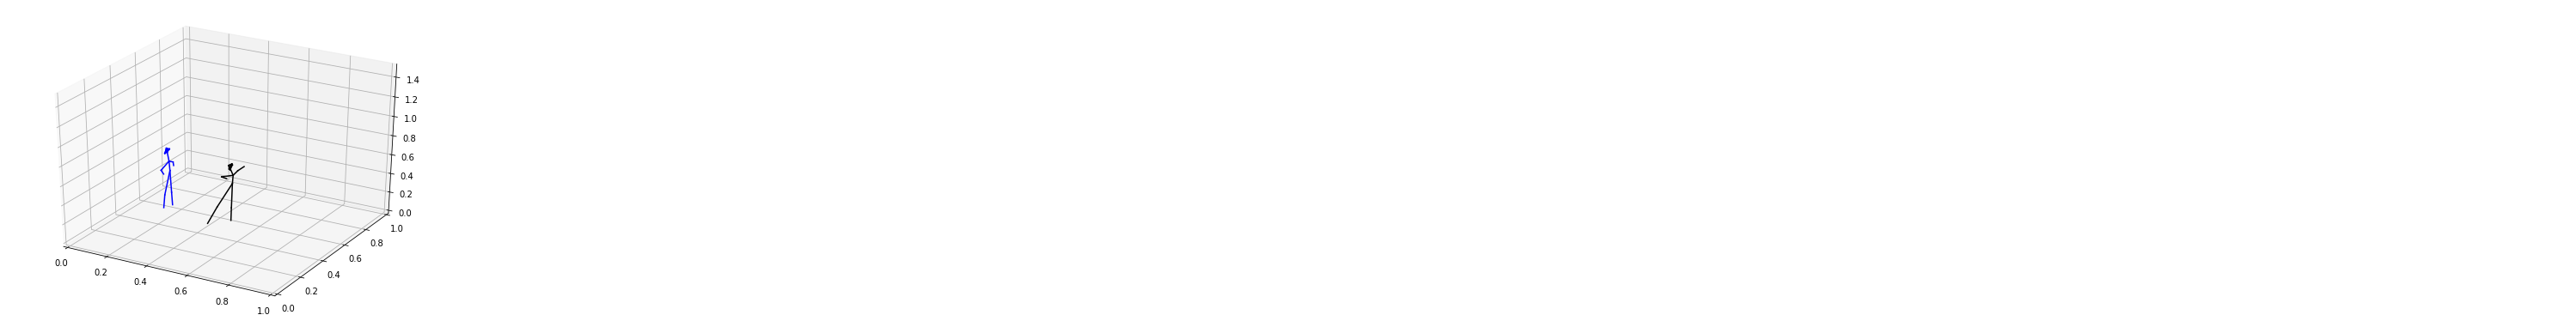

In [16]:
# autoencoded prediction in blue, real data in black:
starting_frame = 16600
n_frames = 100
predictions = ae_nooffset.get_predictions(X_train, start_frame=starting_frame, n_frames=n_frames)
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], predictions, frames=n_frames, edges=data.selected.edges, colors='blue'))

### Train with adding random (x,y) offsets to the input data:

In [18]:
ae_withoffset = Autoencoder(n_verts=15, latent_dim=6, n_layers=2, n_units=128, relu=True, dropout=False, add_random_offsets=False)
X_T = X_train.transpose((1,0,2))
ae_withoffset.model.fit(X_T, X_T, batch_size = 128, epochs = 50)

Epoch 1/50
44309/44309 [==============================] - 2s 51us/step - loss: 0.0120
Epoch 2/50
44309/44309 [==============================] - 2s 43us/step - loss: 0.0012
Epoch 3/50
44309/44309 [==============================] - 2s 43us/step - loss: 8.6569e-04
Epoch 4/50
44309/44309 [==============================] - 2s 43us/step - loss: 6.8760e-04
Epoch 5/50
44309/44309 [==============================] - 2s 44us/step - loss: 6.0969e-04
Epoch 6/50
44309/44309 [==============================] - 2s 43us/step - loss: 5.6495e-04
Epoch 7/50
44309/44309 [==============================] - 2s 44us/step - loss: 5.3243e-04
Epoch 8/50
44309/44309 [==============================] - 2s 43us/step - loss: 5.0752e-04
Epoch 9/50
44309/44309 [==============================] - 2s 43us/step - loss: 4.8837e-04
Epoch 10/50
44309/44309 [==============================] - 2s 44us/step - loss: 4.7247e-04
Epoch 11/50
44309/44309 [==============================] - 2s 43us/step - loss: 4.6021e-04
Epoch 12/50
4430

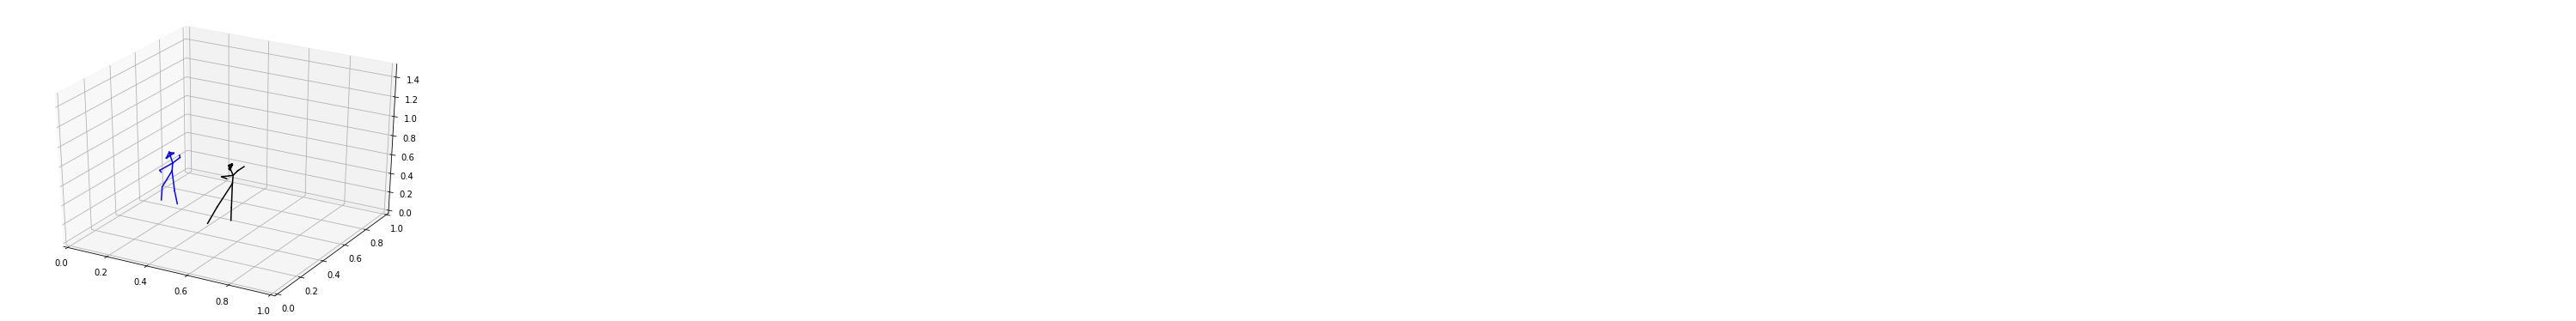

In [19]:
# autoencoded prediction in blue, real data in black:
starting_frame = 16600
n_frames = 100
predictions = ae_withoffset.get_predictions(X_train, start_frame=starting_frame, n_frames=n_frames)
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], predictions, frames=n_frames, edges=data.selected.edges, colors='blue'))

In [ ]:
# Analyze the autoencoder latent space
X = data.selected.X
encoded = []
for idx, i in enumerate(range(X.shape[1])):
  positions = np.expand_dims(X[:,i,:].squeeze(), axis=0)
  encoded.append( ae.encoder.predict(positions) )
  if idx and idx % 10000 == 0:
    print(' * processed', idx, 'of', X.shape[1])
encoded = np.array(encoded).squeeze() # shape = (13463, ae.latent_dim)

# draw the plot
fig = plt.figure(figsize=(20, 14))
ax = p3.Axes3D(fig)
ax.scatter(encoded[:,0], encoded[:,1], encoded[:,2], depthshade=False, alpha=0.3, s=0.5, c=np.arange(len(encoded)))

# LSTM + MDN

In [173]:
# adapted from https://raw.githubusercontent.com/omimo/Keras-MDN/master/kmdn/mdn.py
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Dense, Input, merge, concatenate, Dense, LSTM, CuDNNLSTM
from keras.engine.topology import Layer
from keras import backend as K
import tensorflow_probability as tfp
import tensorflow as tf
from keras.models import load_model


# check tfp version, as tfp causes cryptic error if out of date
assert float(tfp.__version__.split('.')[1]) >= 5

class MDN(Layer):
  '''Mixture Density Network with unigaussian kernel'''
  def __init__(self, n_mixes, output_dim, **kwargs):
    self.n_mixes = n_mixes
    self.output_dim = output_dim

    with tf.name_scope('MDN'):
      self.mdn_mus    = Dense(self.n_mixes * self.output_dim, name='mdn_mus')
      self.mdn_sigmas = Dense(self.n_mixes, activation=K.exp, name='mdn_sigmas')
      self.mdn_alphas = Dense(self.n_mixes, activation=K.softmax, name='mdn_alphas')
    super(MDN, self).__init__(**kwargs)

  def build(self, input_shape):
    self.mdn_mus.build(input_shape)
    self.mdn_sigmas.build(input_shape)
    self.mdn_alphas.build(input_shape)
    self.trainable_weights = self.mdn_mus.trainable_weights + \
      self.mdn_sigmas.trainable_weights + \
      self.mdn_alphas.trainable_weights
    self.non_trainable_weights = self.mdn_mus.non_trainable_weights + \
      self.mdn_sigmas.non_trainable_weights + \
      self.mdn_alphas.non_trainable_weights
    self.built = True

  def call(self, x, mask=None):
    with tf.name_scope('MDN'):
      mdn_out = concatenate([
        self.mdn_mus(x),
        self.mdn_sigmas(x),
        self.mdn_alphas(x)
      ], name='mdn_outputs')
    return mdn_out

  def get_output_shape_for(self, input_shape):
    return (input_shape[0], self.output_dim)

  def get_config(self):
    config = {
      'output_dim': self.output_dim,
      'n_mixes': self.n_mixes,
    }
    base_config = super(MDN, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

  def get_loss_func(self):
    def unigaussian_loss(y_true, y_pred):
      mix = tf.range(start = 0, limit = self.n_mixes)
      out_mu, out_sigma, out_alphas = tf.split(y_pred, num_or_size_splits=[
        self.n_mixes * self.output_dim,
        self.n_mixes,
        self.n_mixes,
      ], axis=-1, name='mdn_coef_split')

      def loss_i(i):
        batch_size = tf.shape(out_sigma)[0]
        sigma_i = tf.slice(out_sigma, [0, i], [batch_size, 1], name='mdn_sigma_slice')
        alpha_i = tf.slice(out_alphas, [0, i], [batch_size, 1], name='mdn_alpha_slice')
        mu_i = tf.slice(out_mu, [0, i * self.output_dim], [batch_size, self.output_dim], name='mdn_mu_slice')
        dist = tfp.distributions.Normal(loc=mu_i, scale=sigma_i)
        loss = dist.prob(y_true) # find the pdf around each value in y_true
        loss = alpha_i * loss
        return loss

      result = tf.map_fn(lambda  m: loss_i(m), mix, dtype=tf.float32, name='mix_map_fn')
      result = tf.reduce_sum(result, axis=0, keepdims=False)
      result = -tf.log(result)
      result = tf.reduce_mean(result)
      return result

    with tf.name_scope('MDNLayer'):
      return unigaussian_loss

class LSTM_MDN:
  def __init__(self, n_verts=15, n_dims=3, n_mixes=2, look_back=1, cells=[32,32,32,32], use_mdn=True):
    self.n_verts = n_verts
    self.n_dims = n_dims
    self.n_mixes = n_mixes
    self.look_back = look_back
    self.cells = cells
    self.use_mdn = use_mdn
    self.LSTM = CuDNNLSTM if len(gpus) > 0 else LSTM
    self.model = self.build_model()
    if use_mdn:
      self.model.compile(loss=MDN(n_mixes, n_verts*n_dims).get_loss_func(), optimizer='adam', metrics=['accuracy'])
    else:
      self.model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    
  def build_model(self):
    i = Input((self.look_back, self.n_verts*self.n_dims))
    h = self.LSTM(self.cells[0], return_sequences=True)(i) # return sequences, stateful
    h = self.LSTM(self.cells[1], return_sequences=True)(h)
    h = self.LSTM(self.cells[2])(h)
    h = Dense(self.cells[3])(h)
    if self.use_mdn:
      o = MDN(self.n_mixes, self.n_verts*self.n_dims)(h)
    else:
      o = Dense(self.n_verts*self.n_dims)(h)
    return Model(inputs=[i], outputs=[o])
  
  def prepare_inputs(self, X, look_back=2):
    '''
    Prepare inputs in shape expected by LSTM
    @returns:
      numpy.ndarray train_X: has shape: n_samples, lookback, verts * dims
      numpy.ndarray train_Y: has shape: n_samples, verts * dims
    '''
    # prepare data for the LSTM_MDN
    X = X.swapaxes(0, 1) # reshape to time, vert, dim
    n_time, n_verts, n_dims = X.shape
    
    # validate shape attributes
    if n_verts != self.n_verts: raise Exception(' ! got', n_verts, 'vertices, expected', self.n_verts)
    if n_dims != self.n_dims: raise Exception(' ! got', n_dims, 'dims, expected', self.n_dims)
    if look_back != self.look_back: raise Exception(' ! got', look_back, 'for look_back, expected', self.look_back)
    
    # lstm expects data in shape [samples_in_batch, timestamps, values]
    train_X = []
    train_Y = []
    for i in range(look_back, n_time, 1):
      train_X.append( X[i-look_back:i,:,:].reshape(look_back, n_verts * n_dims) ) # look_back, verts * dims
      train_Y.append( X[i,:,:].reshape(n_verts * n_dims) ) # verts * dims
    train_X = np.array(train_X) # n_samples, lookback, verts * dims
    train_Y = np.array(train_Y) # n_samples, verts * dims
    return [train_X, train_Y]
  
  def predict_positions(self, input_X):
    '''
    Predict the output for a series of input frames. Each prediction has shape (1, y), where y contains:
      mus = y[:n_mixes*n_verts*n_dims]
      sigs = y[n_mixes*n_verts*n_dims:-n_mixes]
      alphas = softmax(y[-n_mixes:])
    @param numpy.ndarray input_X: has shape: n_samples, look_back, n_verts * n_dims
    @returns:
      numpy.ndarray X: has shape: verts, time, dims
    '''
    predictions = []
    for i in range(input_X.shape[0]):
      y = self.model.predict( train_X[i:i+1] ).squeeze()
      mus = y[:n_mixes*n_verts*n_dims]
      sigs = y[n_mixes*n_verts*n_dims:-n_mixes]
      alphas = self.softmax(y[-n_mixes:])

      # find the most likely distribution then pull out the mus that correspond to that selected index
      alpha_idx = np.argmax(alphas) # 0
      alpha_idx = 0
      predictions.append( mus[alpha_idx*self.n_verts*self.n_dims:(alpha_idx+1)*self.n_verts*self.n_dims] )
    predictions = np.array(predictions).reshape(train_X.shape[0], self.n_verts, self.n_dims).swapaxes(0, 1)
    return predictions # shape = n_verts, n_time, n_dims
    
  def softmax(self, x):
    ''''Compute softmax values for vector `x`'''
    r = np.exp(x - np.max(x))
    return r / r.sum()

In [174]:
X = data.selected.X
n_verts, n_time, n_dims = X.shape
n_mixes = 3
look_back = 10

lstm_mdn = LSTM_MDN(n_verts=n_verts, n_dims=n_dims, n_mixes=n_mixes, look_back=look_back)
train_X, train_Y = lstm_mdn.prepare_inputs(X, look_back=look_back)

lstm_mdn = LSTM_MDN(n_verts=n_verts, n_dims=n_dims, n_mixes=n_mixes, look_back=look_back)
lstm_mdn.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 10, 45)            0         
_________________________________________________________________
cu_dnnlstm_55 (CuDNNLSTM)    (None, 10, 32)            10112     
_________________________________________________________________
cu_dnnlstm_56 (CuDNNLSTM)    (None, 10, 32)            8448      
_________________________________________________________________
cu_dnnlstm_57 (CuDNNLSTM)    (None, 32)                8448      
_________________________________________________________________
dense_19 (Dense)             (None, 32)                1056      
_________________________________________________________________
mdn_37 (MDN)                 (None, 32)                4653      
Total params: 32,717
Trainable params: 32,717
Non-trainable params: 0
_________________________________________________________________


In [223]:
from keras.callbacks import TerminateOnNaN, ModelCheckpoint
# checkpoint_filepath="weights-improvement-{epoch:02d}-{acc:.2f}.h5"
checkpoint_filepath="lstm_nopca_weights_tryagain.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')

In [224]:
# Train the model:
lstm_mdn.model.fit(train_X, train_Y, epochs=10000, batch_size=64, shuffle=False, callbacks=[checkpoint, TerminateOnNaN()])

Epoch 1/10000
44299/44299 [==============================] - 9s 210us/step - loss: -2.4603 - acc: 0.1882

Epoch 00001: acc improved from -inf to 0.18822, saving model to lstm_nopca_weights_tryagain.h5
Epoch 2/10000
44299/44299 [==============================] - 9s 208us/step - loss: -2.6033 - acc: 0.1645

Epoch 00002: acc did not improve from 0.18822
Epoch 3/10000
44299/44299 [==============================] - 9s 208us/step - loss: -2.6834 - acc: 0.2068

Epoch 00003: acc improved from 0.18822 to 0.20684, saving model to lstm_nopca_weights_tryagain.h5
Epoch 4/10000
44299/44299 [==============================] - 9s 208us/step - loss: -2.7311 - acc: 0.1554

Epoch 00004: acc did not improve from 0.20684
Epoch 5/10000
44299/44299 [==============================] - 9s 210us/step - loss: -2.7401 - acc: 0.1762

Epoch 00005: acc did not improve from 0.20684
Epoch 6/10000
44299/44299 [==============================] - 9s 208us/step - loss: -2.7328 - acc: 0.1970

Epoch 00006: acc did not improve 

44299/44299 [==============================] - 9s 208us/step - loss: -2.8082 - acc: 0.2171

Epoch 00053: acc did not improve from 0.28827
Epoch 54/10000
44299/44299 [==============================] - 9s 209us/step - loss: -2.8208 - acc: 0.2086

Epoch 00054: acc did not improve from 0.28827
Epoch 55/10000
44299/44299 [==============================] - 9s 209us/step - loss: -2.8388 - acc: 0.2348

Epoch 00055: acc did not improve from 0.28827
Epoch 56/10000
44299/44299 [==============================] - 9s 207us/step - loss: -2.8089 - acc: 0.1761

Epoch 00056: acc did not improve from 0.28827
Epoch 57/10000
44299/44299 [==============================] - 9s 210us/step - loss: -2.7971 - acc: 0.2206

Epoch 00057: acc did not improve from 0.28827
Epoch 58/10000
44299/44299 [==============================] - 9s 210us/step - loss: -2.7945 - acc: 0.1873

Epoch 00058: acc did not improve from 0.28827
Epoch 59/10000
44299/44299 [==============================] - 9s 211us/step - loss: -2.8254 - acc

/home/cuda/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:338: RuntimeWarning: invalid value encountered in multiply
  self._values[k][0] += v * (current - self._seen_so_far)
/home/cuda/.local/lib/python3.6/site-packages/keras/utils/generic_utils.py:338: RuntimeWarning: invalid value encountered in double_scalars
  self._values[k][0] += v * (current - self._seen_so_far)


In [230]:
trained_model = lstm_mdn
# trained_model.model.load_weights('lstm_nopca_weights-best.h5')

### See how well the model can predict the next frame in the input sequence:

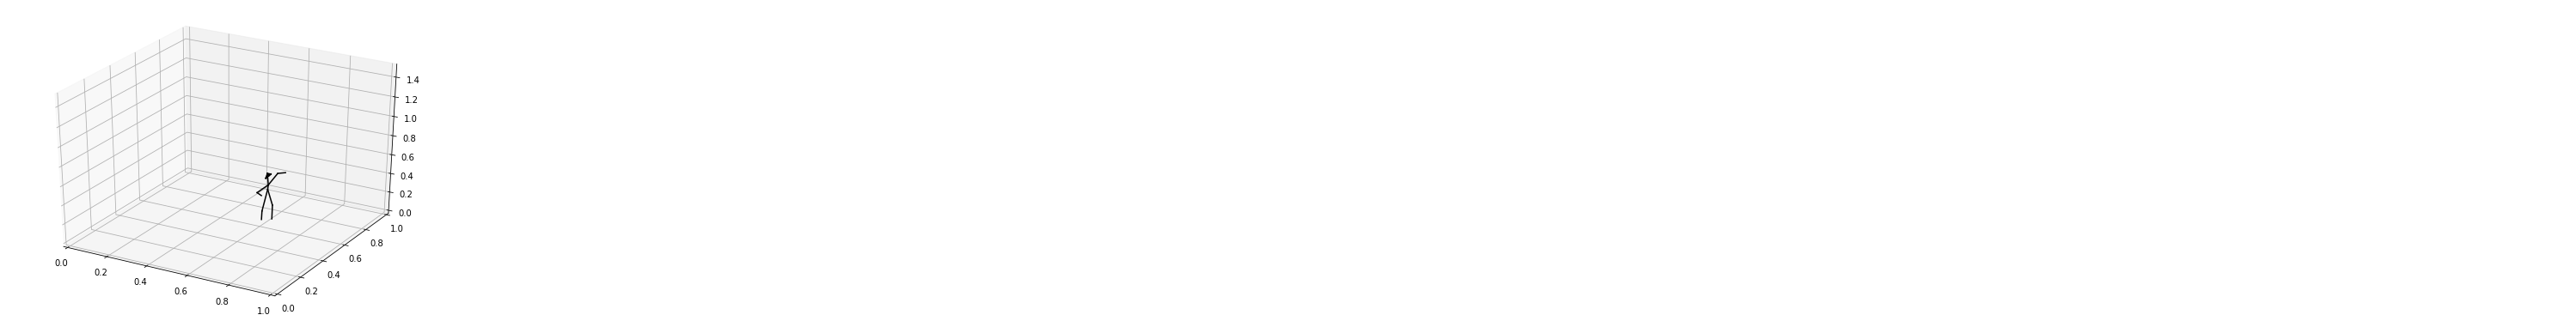

In [231]:
# visualize how well the model learned the input sequence
starting_frame = 1400
n_frames = 100 # n frames of time slices to generate
output_dims = train_X.shape[2]

frames = []

test_X = train_X[starting_frame:starting_frame+n_frames] # data to pass into forward prop through the model
y_pred = trained_model.model.predict(test_X) # output with shape (n_frames, (output_dims+2) * n_mixes )

# partition out the mus, sigs, and mixture weights
for i in range(n_frames):
    y = y_pred[i].squeeze()
    mus = y[:n_mixes*output_dims]
    sigs = y[n_mixes*output_dims:n_mixes*output_dims + n_mixes]
    alphas = y[-n_mixes:]

    # find the most likely distribution - then disregard that number and use the first Gaussian :)
    alpha_idx = np.argmax(alphas)
    alpha_idx = 0

    # pull out the mus that correspond to the selected alpha index
    positions = mus[alpha_idx * output_dims:(alpha_idx+1) * output_dims]
    frames.append(positions)
  
frames = np.array(frames)
lstm_predictions = np.dstack((frames.T[::3,:],frames.T[1::3,:],frames.T[2::3,:]))
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], lstm_predictions[:,:,:], frames=n_frames, edges=data.selected.edges, colors='blue', ghost_shift = 0.3))

In [232]:
predictions = trained_model.predict_positions(train_X)

/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/n

/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/n

/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/n

/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/n

/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/n

/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/n

/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/cuda/anaconda3/lib/python3.6/site-packages/n

KeyboardInterrupt: 

In [ ]:
starting_frame = 1400
n_frames = 100 
HTML(animate_ghost(data.selected.X[:,starting_frame:,:], predictions[:,starting_frame-11:,:], frames=n_frames, edges=data.selected.edges, colors='blue', ghost_shift = 0.3))

# Now generate new sequences!

In [237]:
trained_model.model.predict(x).shape

(1, 141)

In [236]:
n_frames = 100 # n frames of time slices to generate
frames = []

seed = np.random.randint(0, len(train_X)-1)
x = np.expand_dims(train_X[seed], axis=0)
print(' * seeding with', seed)

for i in range(n_frames):
    y = trained_model.model.predict(x).squeeze()
    mus = y[:n_mixes*output_dims]
    sigs = y[n_mixes*output_dims:-n_mixes]
    alphas = softmax(y[-n_mixes:])

    # select the alpha channel to use
    alpha_idx = np.argmax(alphas)

    # grab the mus and sigs associated with the selected alpha_idx
    frame_mus = mus.ravel()[alpha_idx*output_dims : (alpha_idx+1)*output_dims]
    frame_sig = sigs[alpha_idx] / 100

    # now sample from each Gaussian
    positions = [np.random.normal(loc=m, scale=frame_sig) for m in frame_mus]
    positions = frame_mus

    # add these positions to the results
    frames.append(positions)

    # pull out a new training example - stack the new result on
    # all values after the first from the bottom-most value in the x's
    start = x[:,1:,:]
    end = np.expand_dims( np.expand_dims(positions, axis=0), axis=0 )
    x = np.concatenate((start, end), axis=1)
    
frames = np.array(frames)
lstm_predictions = np.dstack((frames.T[::3,:],frames.T[1::3,:],frames.T[2::3,:]))

prompt_plus_generated_seq = np.concatenate((data.selected.X[:,seed:seed+10,:],lstm_predictions), axis=1)

HTML(animate(prompt_plus_generated_seq, frames=n_frames, edges=data.selected.edges, colors='black'))

 * seeding with 4120


/home/cuda/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


IndexError: index 0 is out of bounds for axis 0 with size 0

NEXT STEPS:
- (x,y centering)
- augment with random rotations